In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Load datasets ---
weather = pd.read_csv("/content/drive/My Drive/CW Data/weather_data_2024.csv", parse_dates=["Timestamp"])
mfdt = pd.read_csv("/content/drive/My Drive/CW Data/makeup_data_2024.csv", parse_dates=["Timestamp"])
makeup = pd.read_csv("/content/drive/My Drive/CW Data/makeup_flow_2024.csv", parse_dates=["Timestamp"])
buildings = pd.read_csv(
    "/content/drive/My Drive/CW Data/summary_data_2024.csv",
    names=["Building", "Meter", "Timestamp", "Flow", "DeltaT", "MixTemp", "StationCO"],
)

# Clean up
buildings.dropna(inplace=True)
weather.dropna(inplace=True)
mfdt.dropna(inplace=True)
makeup.dropna(inplace=True)
buildings['Timestamp'] = pd.to_datetime(buildings['Timestamp'])

# --- Pivot buildings ---
building_wide = buildings.pivot_table(
    index="Timestamp",
    columns=["Building", "Meter"],
    values=["Flow", "DeltaT", "StationCO"]
)
building_wide.columns = [f"{b}_{m}_{f}" for f, b, m in building_wide.columns]
building_wide.reset_index(inplace=True)

# --- Merge weather + makeup ---
# Merge weather and makeup first
combined_df = pd.merge(
    weather.rename(columns={'values': 'heatIndex'}),
    makeup.rename(columns={'values': 'makeupFlow'}),
    on='Timestamp',
    how='inner'
)
# Then merge the result with mfdt
combined_df = pd.merge(
    combined_df,
    mfdt.rename(columns={'values': 'MFDT'}),
    on='Timestamp',
    how='inner'
)
# --- Merge everything ---
full_df = pd.merge(building_wide, combined_df, on="Timestamp", how="inner")

# Drop constant features
constant_cols = full_df.columns[full_df.std() == 0]
full_df.drop(columns=constant_cols, inplace=True)

# Drop NaNs and separate timestamps
full_df = full_df.dropna()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# --- Identify building attribute columns
building_cols = [col for col in full_df.columns if any(key in col for key in ['_Flow', '_DeltaT', '_StationCO'])]

# --- Prepare regression input and output
X = full_df[['heatIndex']].values
residual_df = pd.DataFrame({'Timestamp': full_df['Timestamp']})

# --- Compute residuals for each building attribute
for col in building_cols:
    y = full_df[col].values
    model = LinearRegression()
    model.fit(X, y)
    predicted = model.predict(X)
    residual_df[col] = y - predicted

# --- Add MFDT and makeupFlow columns back
residual_df['MFDT'] = full_df['MFDT'].values
residual_df['makeupFlow'] = full_df['makeupFlow'].values


In [5]:
# Scale the data
scaler = MinMaxScaler()
# Exclude the 'Timestamp' column from scaling

# also exclude makeupFlow

numerical_features = residual_df.select_dtypes(include=['number']).drop(columns=['MFDT'])

# Scale the numerical features
X_scaled_temp = pd.DataFrame(scaler.fit_transform(numerical_features), columns=numerical_features.columns, index=residual_df.index)

# Create the final DataFrame with 'Timestamp' and 'MFDT' at the beginning
X_scaled = pd.DataFrame({'Timestamp': residual_df['Timestamp'], 'MFDT': residual_df['MFDT']})
# Concatenate the scaled features
X_scaled = pd.concat([X_scaled, X_scaled_temp], axis=1)


In [6]:
X_scaled['Leak'] = X_scaled['MFDT'] >= 10000
X_scaled[X_scaled['Leak']==True]

,Timestamp,MFDT,Adler Journalism and Mass Communication Building_CWP_AJB_C70_DeltaT,Art Building West_CWP_ABW_C72_DeltaT,Art Building West_CWP_ABW_C73_DeltaT,Becker Communication Studies Building_CWP_BCSB_C49_DeltaT,Biology Building_CWP_BB_C45_DeltaT,Biology Building_CWP_BB_C57_DeltaT,Biology Building East_CWP_BBE_C27_DeltaT,Blank Honors Center_CWP_BHC_C34_DeltaT,...,University Capitol Centre_CWP_UCC_C81_StationCO,Van Allen Hall_CWP_VAN_C47_StationCO,Visual Arts Building_CWP_VAB_C111_StationCO,Voxman Music Building_CWP_VOX_C113_StationCO,Wendell Johnson Speech and Hearing Center_CWP_SHC_C51_StationCO,West Campus Transportation Center_CWP_WCTC_C102_StationCO,West Campus Transportation Center_CWP_WCTC_C103_StationCO,Westlawn_CWP_WL_C50_StationCO,makeupFlow,Leak
188,2024-01-16 16:00:00+00:00,10121.821021,0.779231,0.039953,0.039956,0.577132,0.547149,0.834390,0.866328,0.548484,...,0.483239,0.330224,0.521008,0.361391,0.863411,0.236604,0.357305,0.705300,0.034898,True
189,2024-01-16 18:00:00+00:00,10466.878682,0.757455,0.055560,0.055565,0.567838,0.555018,0.830805,0.835949,0.532333,...,0.465240,0.317057,0.513541,0.337100,0.831833,0.236167,0.343467,0.691735,0.075243,True
190,2024-01-16 20:00:00+00:00,10793.025193,0.740448,0.515994,0.515965,0.560982,0.588960,0.827402,0.813124,0.519822,...,0.451694,0.307148,0.472181,0.318818,0.808067,0.235838,0.333052,0.676467,0.085049,True
191,2024-01-16 22:00:00+00:00,11098.493902,0.737754,0.700003,0.699956,0.560082,0.603659,0.826616,0.810486,0.518141,...,0.449480,0.305528,0.471636,0.315829,0.804181,0.235785,0.331349,0.686999,0.066805,True
192,2024-01-17 00:00:00+00:00,11418.269455,0.745772,0.698574,0.698526,0.563978,0.583334,0.827658,0.823771,0.524288,...,0.456701,0.310810,0.510174,0.325575,0.816851,0.235960,0.336901,0.667849,0.045949,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3842,2024-11-16 04:00:00+00:00,10870.732475,0.431150,0.713621,0.713597,0.439192,0.450122,0.210945,0.621308,0.386306,...,0.215194,0.131033,0.179876,0.355390,0.385684,0.230534,0.930282,0.163790,0.123165,True
3853,2024-11-17 02:00:00+00:00,10082.031701,0.424851,0.712265,0.712243,0.423491,0.499200,0.316984,0.404326,0.316001,...,0.200549,0.123016,0.174497,0.382917,0.366458,0.230411,0.921856,0.359702,0.134691,True
3854,2024-11-17 04:00:00+00:00,10285.315878,0.422208,0.691160,0.691140,0.420388,0.522432,0.321116,0.393715,0.313185,...,0.199586,0.120851,0.173033,0.375344,0.361264,0.230352,0.919577,0.157638,0.139679,True
3865,2024-11-18 02:00:00+00:00,10381.833806,0.429160,0.720139,0.720115,0.417941,0.320929,0.352145,0.639792,0.314118,...,0.203830,0.125452,0.177101,0.371578,0.372300,0.230647,0.924416,0.351738,0.128532,True


In [7]:
X_scaled[X_scaled['Leak']==True]

building_df = X_scaled.copy()

In [8]:
import warnings
warnings.filterwarnings('ignore')

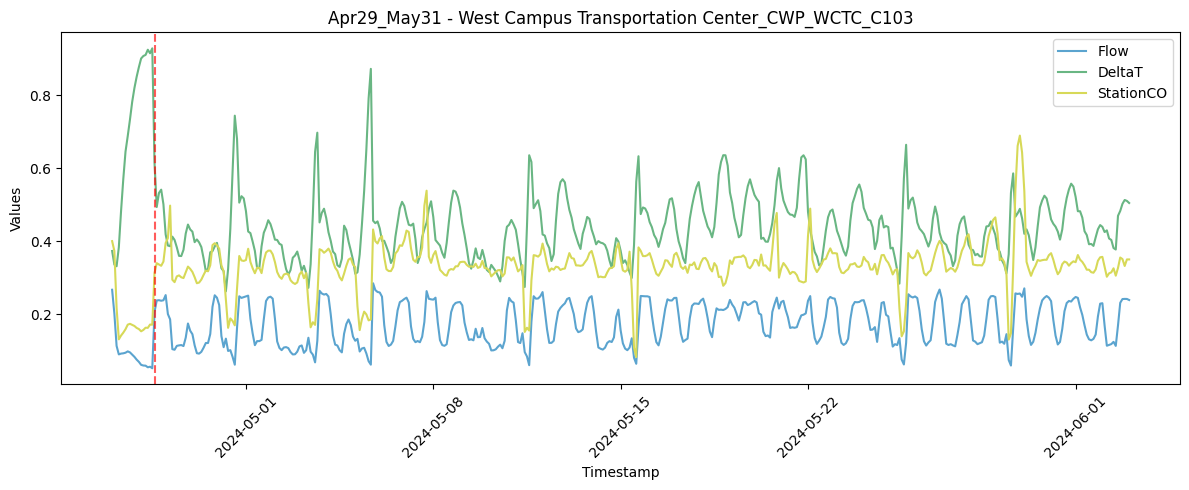

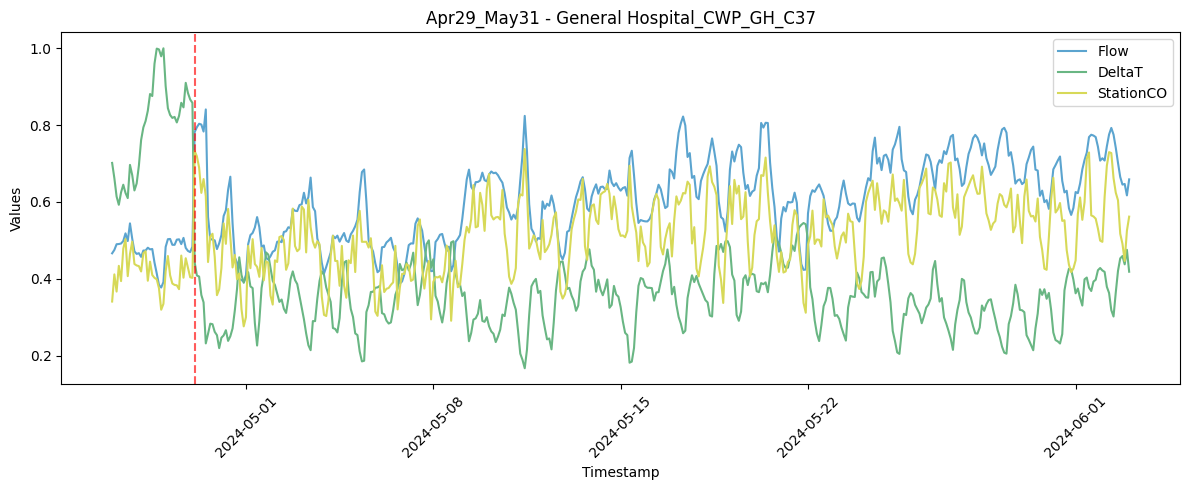

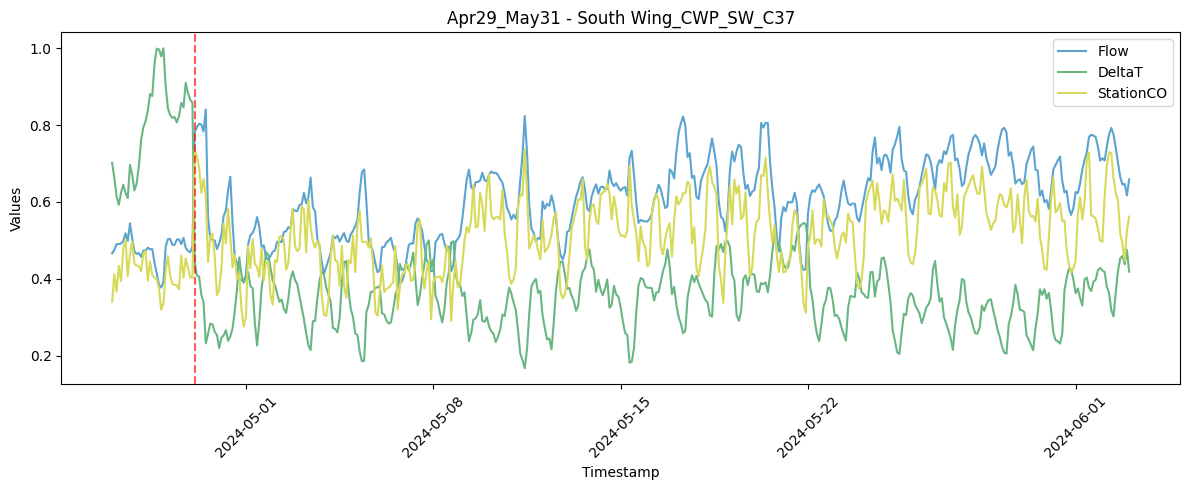

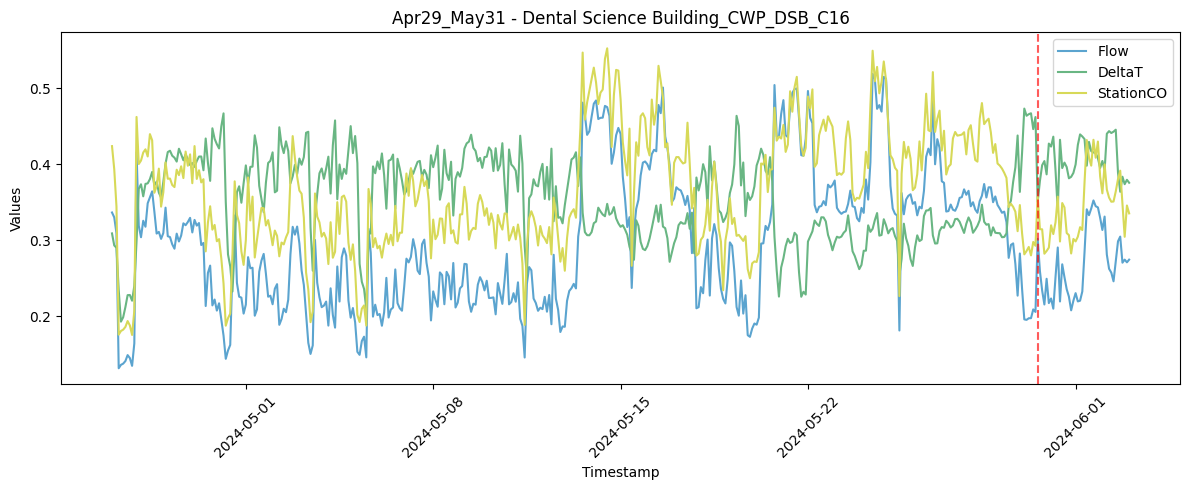

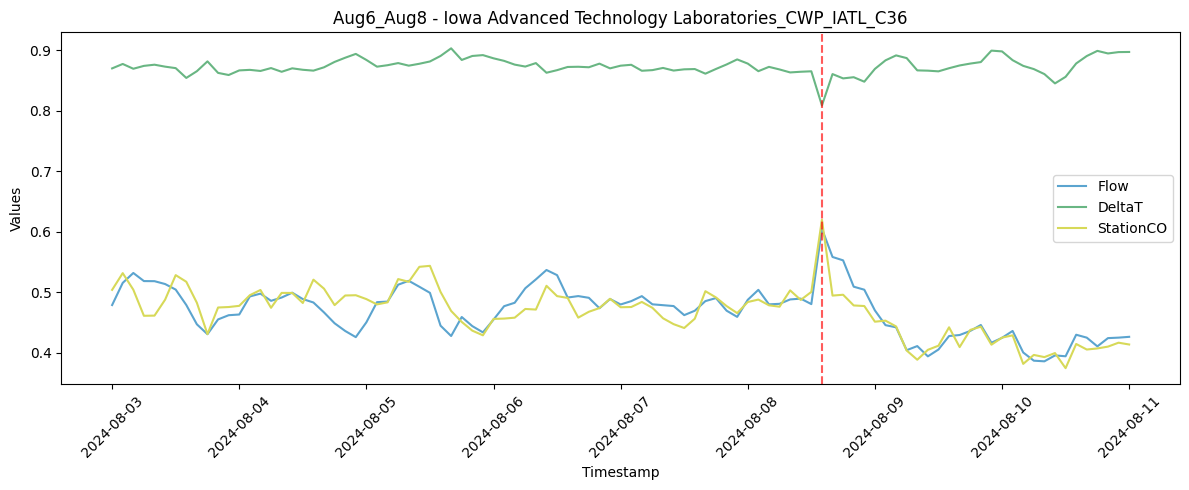

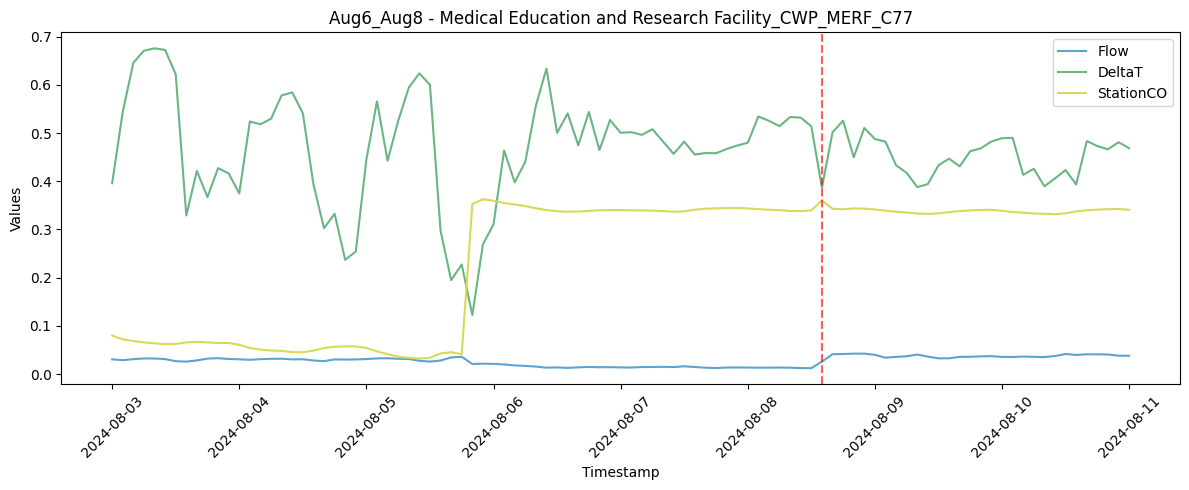

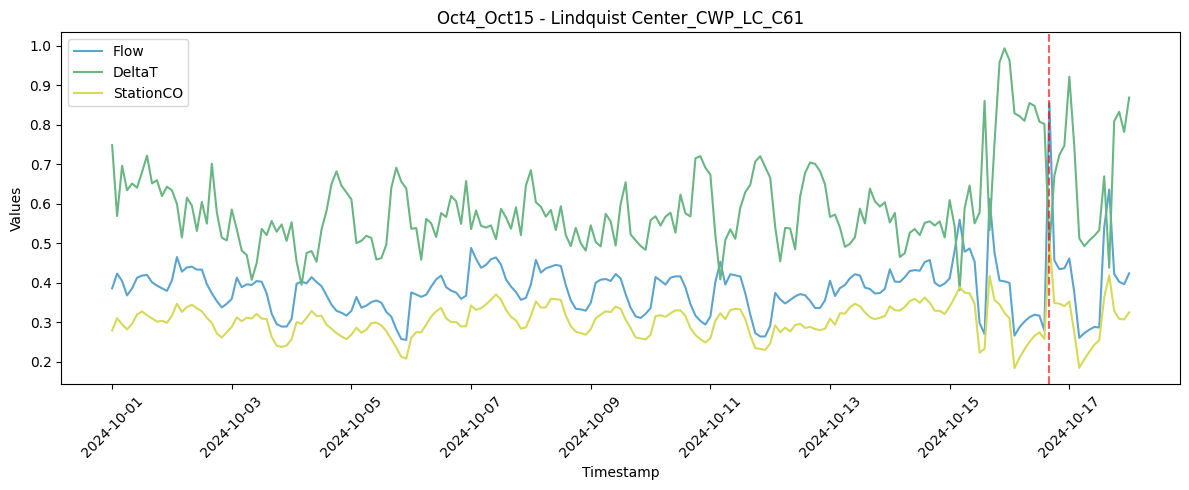

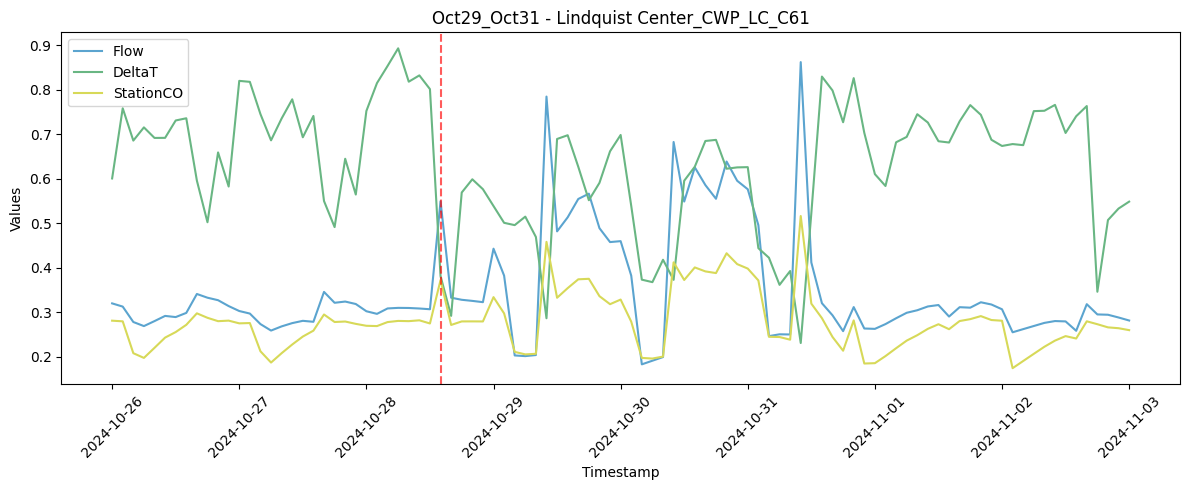

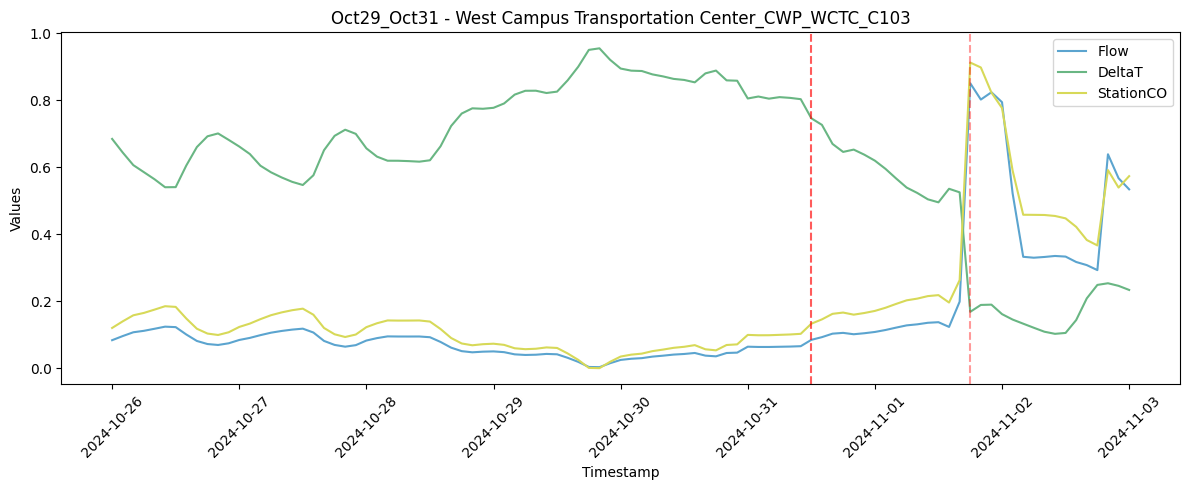

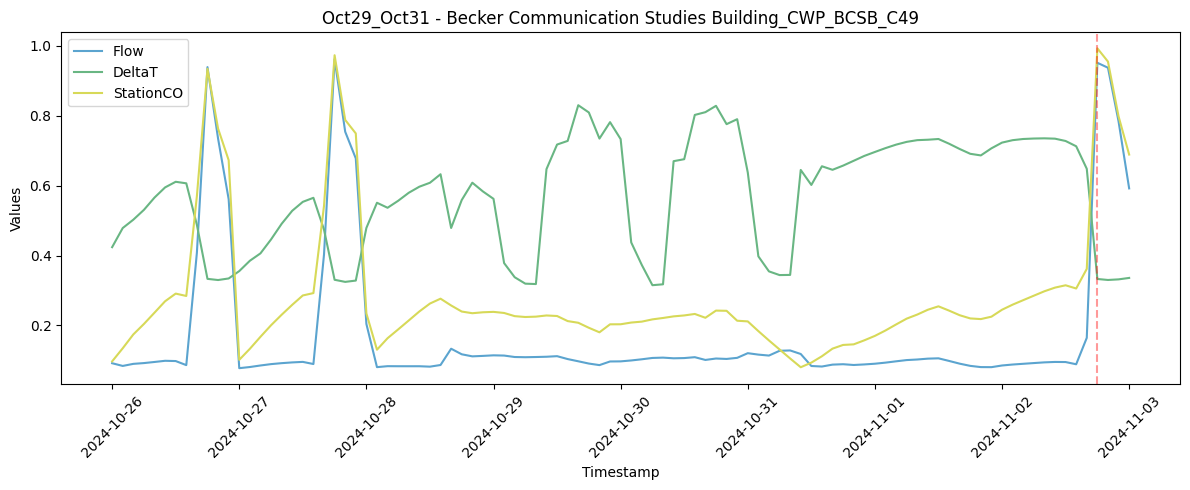


Apr29_May31 Leak Signature Summary:
Triggered early: ['West Campus Transportation Center_CWP_WCTC_C103']
Joined later: ['General Hospital_CWP_GH_C37', 'South Wing_CWP_SW_C37', 'Dental Science Building_CWP_DSB_C16']

Aug6_Aug8 Leak Signature Summary:
Triggered early: ['Iowa Advanced Technology Laboratories_CWP_IATL_C36', 'Medical Education and Research Facility_CWP_MERF_C77']
Joined later: None

Oct4_Oct15 Leak Signature Summary:
Triggered early: ['Lindquist Center_CWP_LC_C61']
Joined later: None

Oct29_Oct31 Leak Signature Summary:
Triggered early: ['Lindquist Center_CWP_LC_C61']
Joined later: ['West Campus Transportation Center_CWP_WCTC_C103', 'Becker Communication Studies Building_CWP_BCSB_C49']


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Define leak periods (with buffer) ---
leak_periods = {
    "Apr29_May31": ("2024-04-26", "2024-06-03"),
    "Aug6_Aug8": ("2024-08-03", "2024-08-11"),
    "Oct4_Oct15": ("2024-10-01", "2024-10-18"),
    "Oct29_Oct31": ("2024-10-26", "2024-11-03")
}

# --- Define signature columns ---
flow_cols = [col for col in building_df.columns if '_Flow' in col]
deltaT_cols = [col for col in building_df.columns if 'DeltaT' in col]
co_cols = [col for col in building_df.columns if 'StationCO' in col]

rolling_window = 7
std_threshold = 2.2

# --- Create spike flags ---
for col in flow_cols + deltaT_cols + co_cols:
    rolling_mean = building_df[col].rolling(rolling_window, min_periods=1).mean()
    rolling_std = building_df[col].rolling(rolling_window, min_periods=1).std()
    if '_DeltaT' in col:
        spike = building_df[col] < (rolling_mean - std_threshold * rolling_std)
    else:
        spike = building_df[col] > (rolling_mean + std_threshold * rolling_std)
    building_df[col + '_sig_spike'] = spike.astype(int)

# --- Collect summaries for later print ---
summary_prints = []

# --- Analyze and plot ---
for label, (start, end) in leak_periods.items():
    period_df = building_df[(building_df['Timestamp'] >= start) & (building_df['Timestamp'] <= end)]

    signature_records = []
    for idx, row in period_df.iterrows():
        timestamp = row['Timestamp']
        for flow_col in flow_cols:
            meter = '_'.join(flow_col.split('_')[:4])
            deltaT_col = f'{meter}_DeltaT'
            co_col = f'{meter}_StationCO'
            flow_spike = row.get(flow_col + '_sig_spike', 0)
            deltaT_spike = row.get(deltaT_col + '_sig_spike', 0)
            co_spike = row.get(co_col + '_sig_spike', 0)
            leak_signature = int(flow_spike and deltaT_spike and co_spike)
            if leak_signature:
                signature_records.append((timestamp, meter))

    if signature_records:
        culprits_by_meter = defaultdict(list)
        for ts, meter in signature_records:
            culprits_by_meter[meter].append(ts)

        for meter in culprits_by_meter:
            flow_col = f'{meter}_Flow'
            deltaT_col = f'{meter}_DeltaT'
            co_col = f'{meter}_StationCO'
            df = period_df[['Timestamp', flow_col, deltaT_col, co_col]].dropna()
            plt.figure(figsize=(12, 5))
            plt.plot(df['Timestamp'], df[flow_col], label='Flow', color='#5ba4cf')
            plt.plot(df['Timestamp'], df[deltaT_col], label='DeltaT', color='#69b683')
            plt.plot(df['Timestamp'], df[co_col], label='StationCO', color='#d7d958')
            spikes = culprits_by_meter[meter]
            for t in spikes:
                plt.axvline(t, color='red', linestyle='--', alpha=0.4)
            plt.title(f'{label} - {meter}')
            plt.xlabel('Timestamp')
            plt.ylabel('Values')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # Collect summary for printing later
        earliest_date = min(ts for ts, _ in signature_records)
        early_culprits = [m for m, times in culprits_by_meter.items() if min(times) <= earliest_date + pd.Timedelta(hours=2)]
        late_culprits = [m for m in culprits_by_meter if m not in early_culprits]

        summary = f"\n{label} Leak Signature Summary:\n" + \
                  f"Triggered early: {early_culprits if early_culprits else 'None'}\n" + \
                  f"Joined later: {late_culprits if late_culprits else 'None'}"
        summary_prints.append(summary)
    else:
        summary_prints.append(f"\nNo leak signature match found for {label}. Try lowering std_threshold.")

# --- Print all summaries after plots ---
for s in summary_prints:
    print(s)


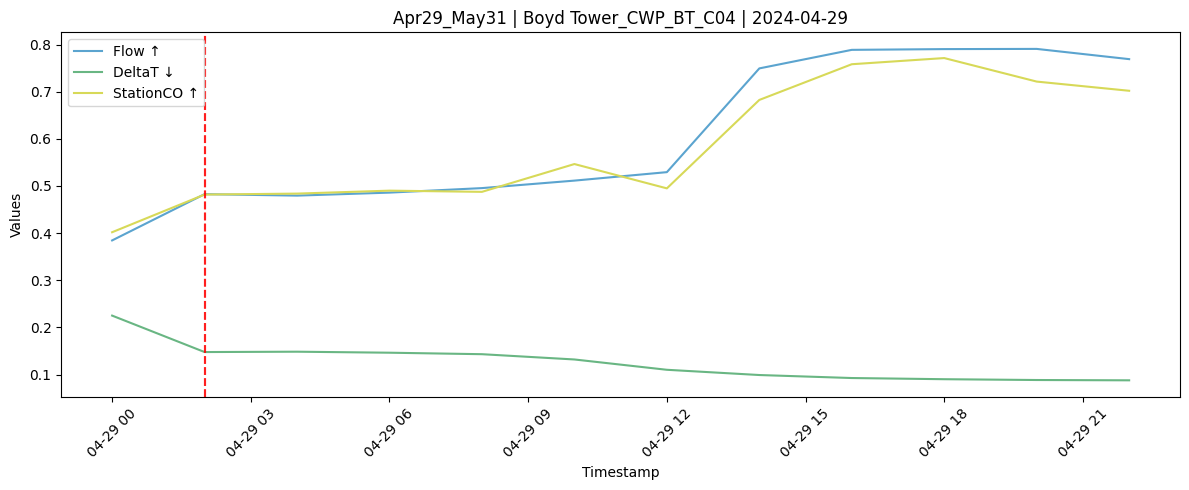

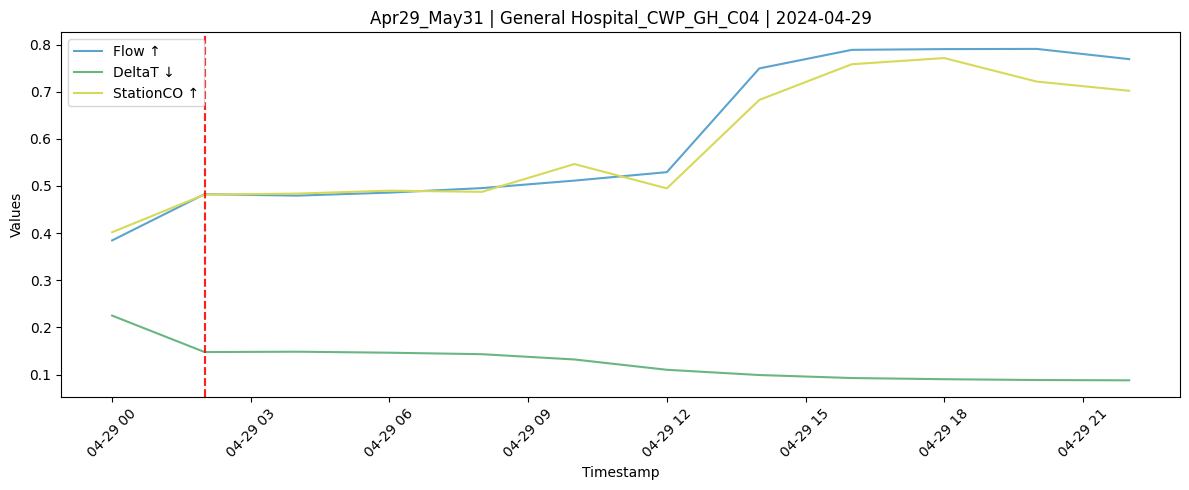

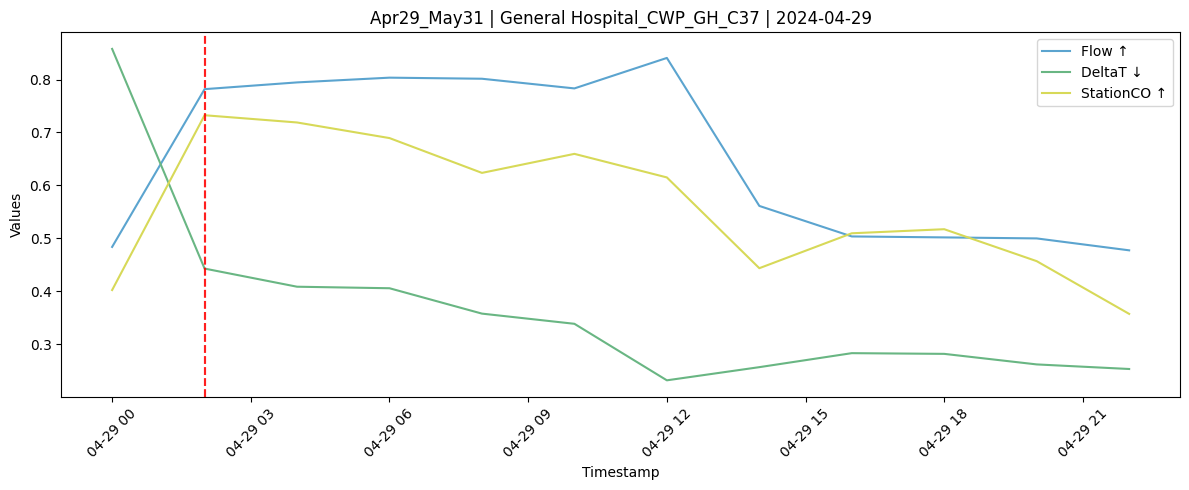

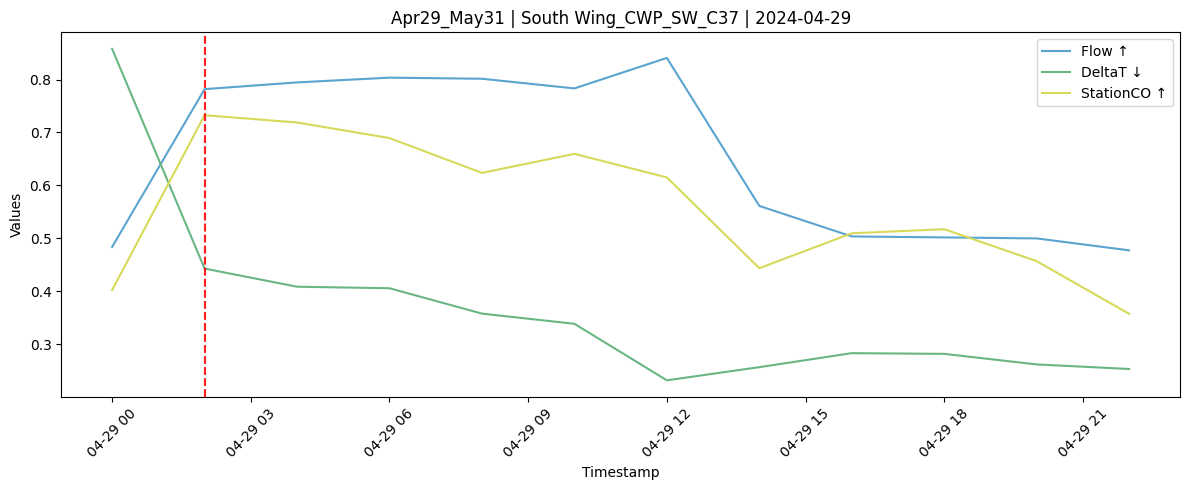

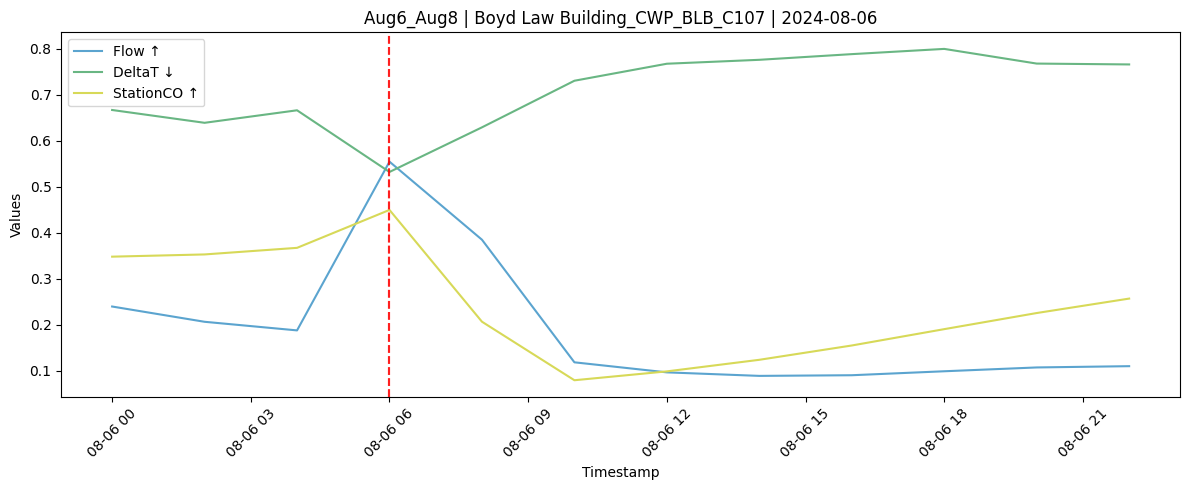

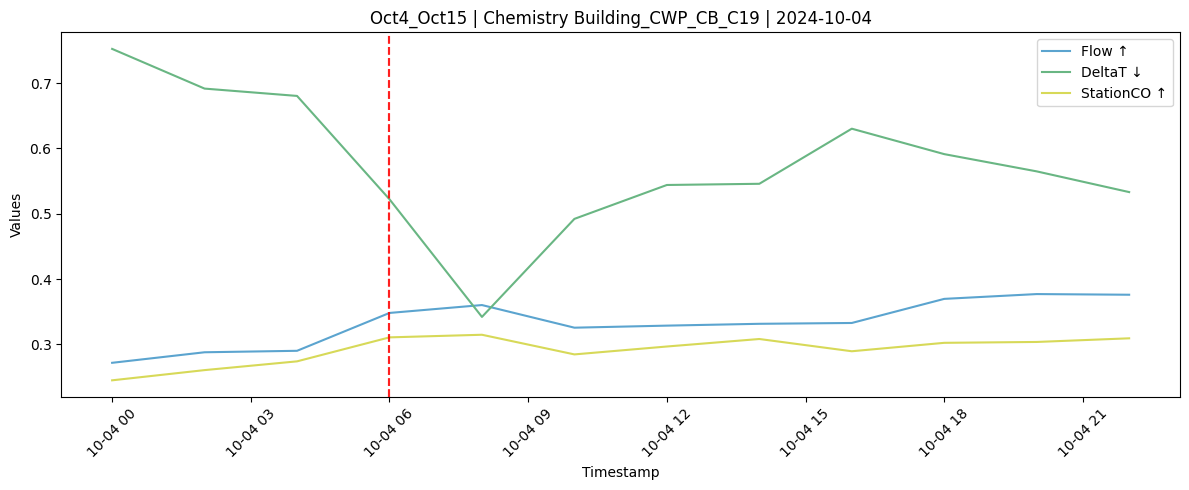

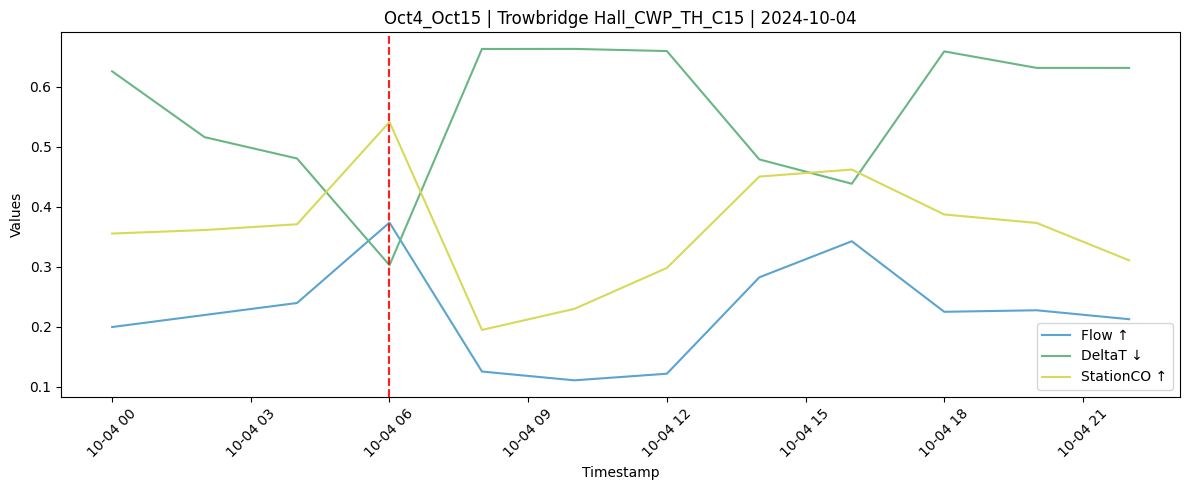

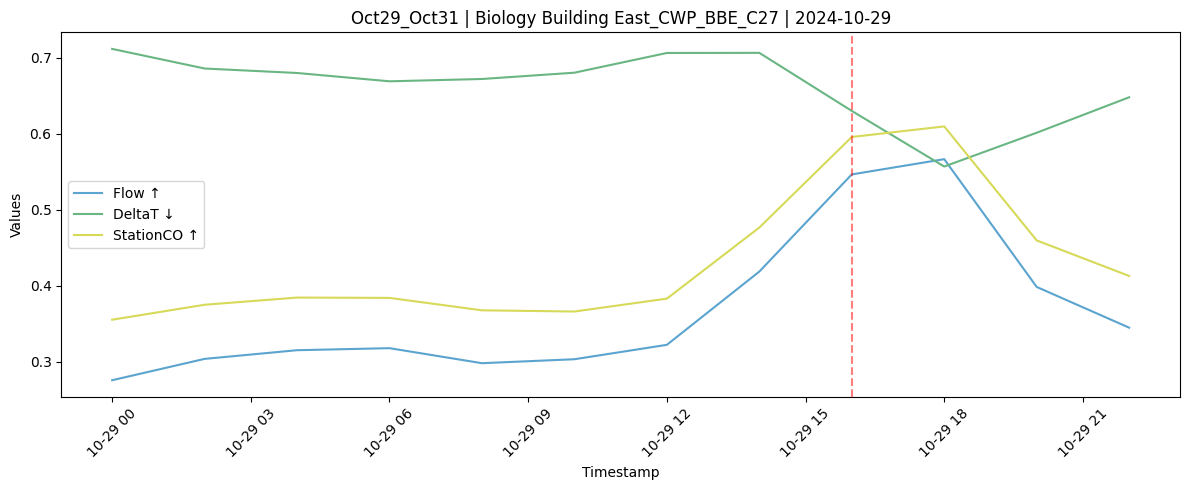

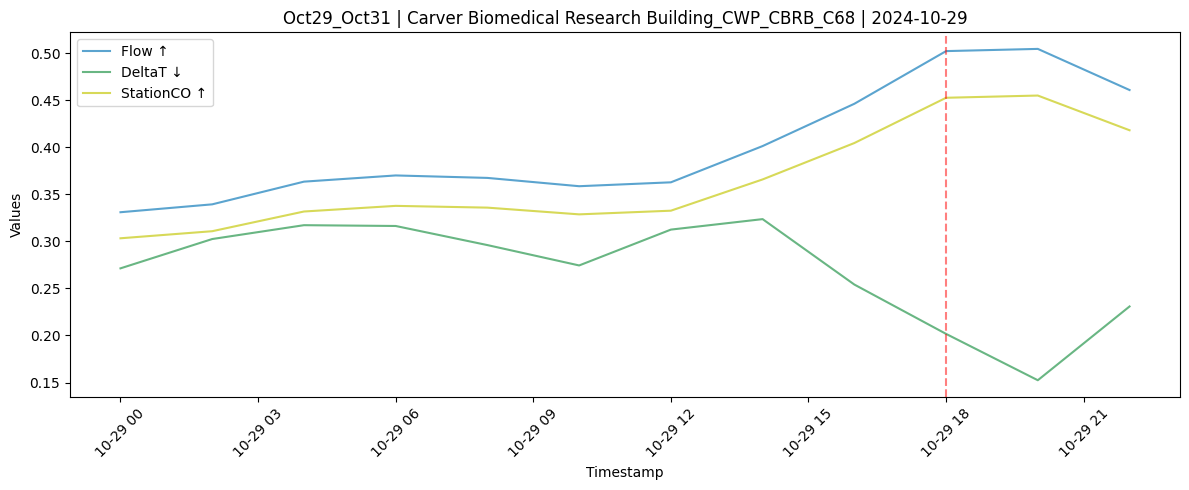

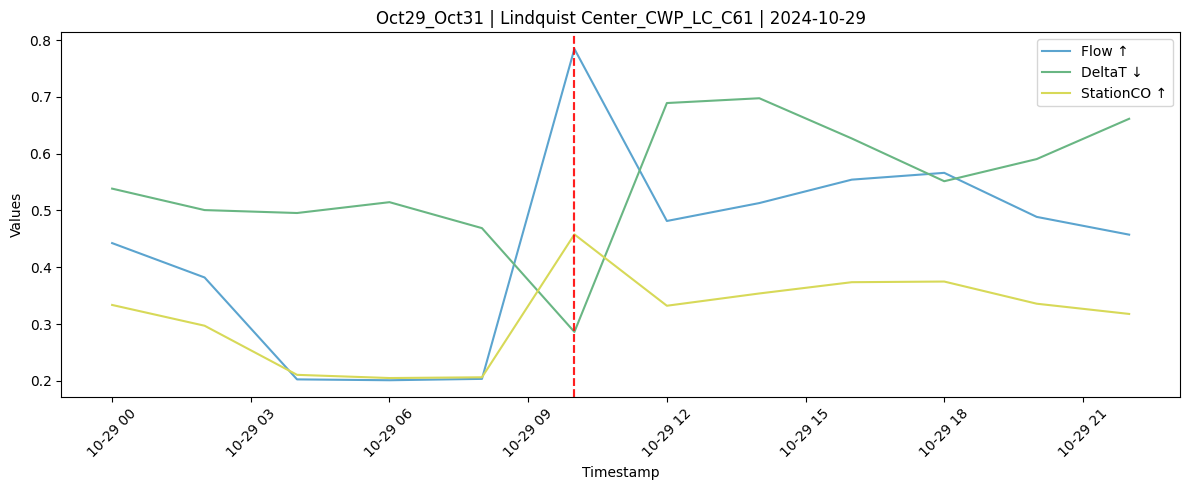

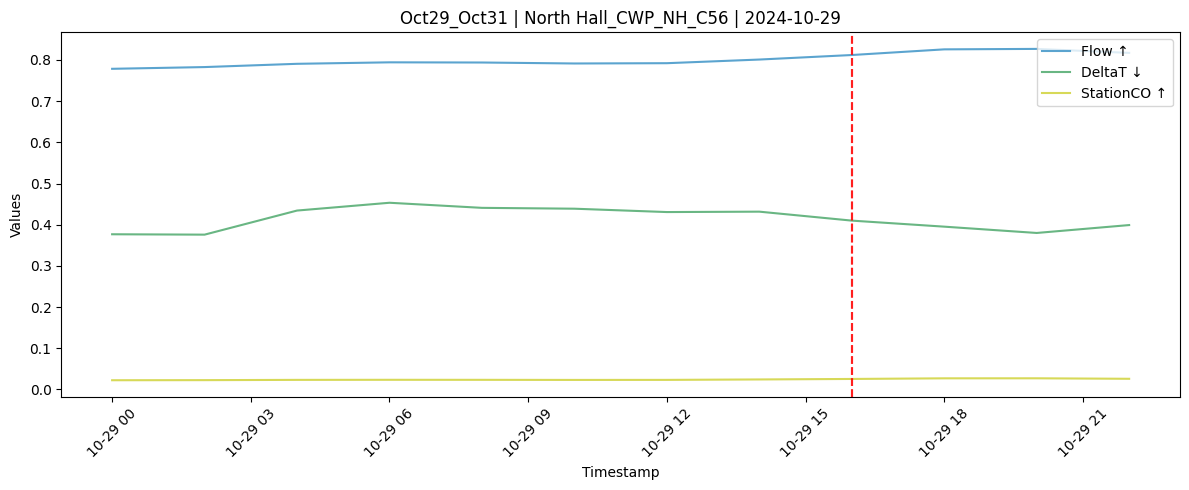

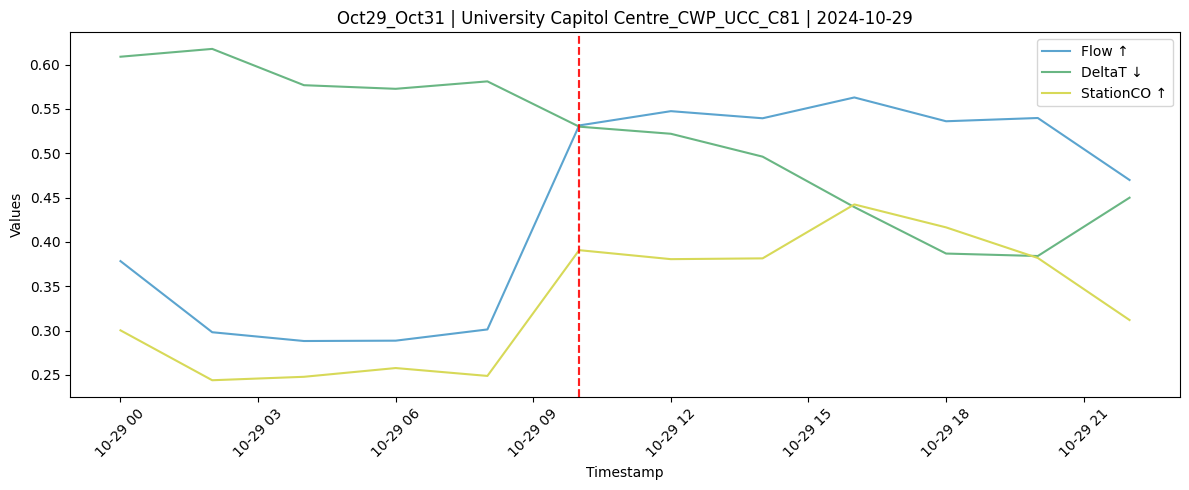


Leak Start Day – Apr29_May31
Culprit Building-Meters:
Boyd Tower_CWP_BT_C04
General Hospital_CWP_GH_C04
General Hospital_CWP_GH_C37
South Wing_CWP_SW_C37

Leak Start Day – Aug6_Aug8
Culprit Building-Meters:
Boyd Law Building_CWP_BLB_C107

Leak Start Day – Oct4_Oct15
Culprit Building-Meters:
Chemistry Building_CWP_CB_C19
Trowbridge Hall_CWP_TH_C15

Leak Start Day – Oct29_Oct31
Culprit Building-Meters:
Biology Building East_CWP_BBE_C27
Carver Biomedical Research Building_CWP_CBRB_C68
Lindquist Center_CWP_LC_C61
North Hall_CWP_NH_C56
University Capitol Centre_CWP_UCC_C81


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# --- Leak start dates ---
leak_day_targets = {
    "Apr29_May31": "2024-04-29",
    "Aug6_Aug8": "2024-08-06",
    "Oct4_Oct15": "2024-10-04",
    "Oct29_Oct31": "2024-10-29"
}

# --- Identify signature columns ---
flow_cols = [col for col in building_df.columns if '_Flow' in col]
deltaT_cols = [col for col in building_df.columns if 'DeltaT' in col]
co_cols = [col for col in building_df.columns if 'StationCO' in col]

rolling_window = 7
std_threshold = 1.8

# --- Create spike flags ---
for col in flow_cols + deltaT_cols + co_cols:
    rolling_mean = building_df[col].rolling(rolling_window, min_periods=1).mean()
    rolling_std = building_df[col].rolling(rolling_window, min_periods=1).std()
    if '_DeltaT' in col:
        spike = building_df[col] < (rolling_mean - std_threshold * rolling_std)
    else:
        spike = building_df[col] > (rolling_mean + std_threshold * rolling_std)
    building_df[col + '_sig_spike'] = spike.astype(int)

# --- Analyze and plot for each start day ---
culprit_summary = {}

for label, leak_day in leak_day_targets.items():
    day_df = building_df[building_df['Timestamp'].dt.date == pd.to_datetime(leak_day).date()]
    signature_records = []

    for idx, row in day_df.iterrows():
        for flow_col in flow_cols:
            meter = '_'.join(flow_col.split('_')[:4])
            deltaT_col = f'{meter}_DeltaT'
            co_col = f'{meter}_StationCO'

            if all(col + '_sig_spike' in building_df.columns for col in [flow_col, deltaT_col, co_col]):
                flow_spike = row.get(flow_col + '_sig_spike', 0)
                deltaT_spike = row.get(deltaT_col + '_sig_spike', 0)
                co_spike = row.get(co_col + '_sig_spike', 0)

                if flow_spike and deltaT_spike and co_spike:
                    signature_records.append((row['Timestamp'], meter))

    culprits = sorted(set(m for _, m in signature_records))
    culprit_summary[label] = culprits

    # --- Plot each culprit ---
    for meter in culprits:
        flow_col = f'{meter}_Flow'
        deltaT_col = f'{meter}_DeltaT'
        co_col = f'{meter}_StationCO'
        subset = day_df[['Timestamp', flow_col, deltaT_col, co_col]].dropna()

        plt.figure(figsize=(12, 5))
        plt.plot(subset['Timestamp'], subset[flow_col], label='Flow ↑', color='#5ba4cf')
        plt.plot(subset['Timestamp'], subset[deltaT_col], label='DeltaT ↓', color='#69b683')
        plt.plot(subset['Timestamp'], subset[co_col], label='StationCO ↑', color='#d7d958')

        for ts, m in signature_records:
            if m == meter:
                plt.axvline(ts, color='red', linestyle='--', alpha=0.5)

        plt.title(f"{label} | {meter} | {leak_day}")
        plt.xlabel('Timestamp')
        plt.ylabel('Values')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

# --- Print summary of culprits ---
for period, meters in culprit_summary.items():
    print(f"\nLeak Start Day – {period}")
    if meters:
        print("Culprit Building-Meters:")
        for m in meters:
            print(f"{m}")
    else:
        print("No matching leak signatures detected on start day.")
